# Workload evaluation

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# get access to our utility scripts
import sys
utils_path = "../utils/"
if not utils_path in sys.path:
    sys.path.insert(0, utils_path)
from helper import *

## Data loading

In [3]:
df1 = pd.read_csv("workloads/job-full-run1-cout.csv")
df1["run"] = 1
df1.plan = df1.plan.apply(json.loads)

df2 = pd.read_csv("workloads/job-full-run2-cout.csv")
df2["run"] = 2
df2.plan = df2.plan.apply(json.loads)

df3 = pd.read_csv("workloads/job-full-run3-cout.csv")
df3["run"] = 3
df3.plan = df3.plan.apply(json.loads)

df_baseline = pd.read_csv("workloads/job-baseline-cout.csv")
df_baseline["run"] = "baseline"
df_baseline.plan = df_baseline.plan.apply(json.loads)

df_bao = pd.concat([df1, df2, df3])

df_all = pd.concat([df_bao, df_baseline])
df_all

,query,cout,plan,t_exec,t_plan,label,run
0,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",9359,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1606.537,35.043,3c,1
1,"SELECT COUNT(*) FROM company_type AS ct, info_...",46974,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",240.636,35.156,1d,1
2,"SELECT COUNT(*) FROM aka_title AS at, company_...",39302,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1062.299,55.536,15d,1
3,"SELECT COUNT(*) FROM complete_cast AS cc, comp...",1358376,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",3842.651,190.036,28c,1
4,"SELECT COUNT(*) FROM company_name AS cn1, comp...",8949,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",405.442,208.050,33a,1
...,...,...,...,...,...,...,...
108,"SELECT COUNT(*) FROM company_name AS cn1, comp...",3403,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",4.803,71.582,33b,baseline
109,"SELECT COUNT(*) FROM cast_info AS ci, info_typ...",74312,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",792.727,2.453,18b,baseline
110,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",8715,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",100.883,0.830,3a,baseline
111,"SELECT COUNT(*) FROM info_type AS it1, info_ty...",13541,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",104.013,4.099,14b,baseline


## Analyzing the query execution time across different runs

In [4]:
grp_run = df_all.groupby("run")

Aggregated information for the different runs:

In [5]:
grp_run.t_exec.describe()

,count,mean,std,min,25%,50%,75%,max
run,,,,,,,,
1,113.0,8422.204991,48049.378525,128.043,1115.723,2183.638,3105.081,504904.168
2,113.0,2272.411319,2779.032734,123.933,931.638,1952.100,2780.955,27683.457
3,113.0,2054.798841,1325.289235,126.632,936.051,1953.915,2915.382,7331.436
baseline,113.0,5025.080496,15981.614976,2.924,128.803,698.284,4043.859,129587.619


Total query execution time [minutes]:

In [6]:
(grp_run.t_exec.sum() + grp_run.t_plan.sum()) / 60000

run
1           16.072971
2            4.502082
3            4.091946
baseline     9.500353
dtype: float64

Raw query execution time (no planning) [minutes]:

In [7]:
grp_run.t_exec.sum() / 60000

run
1           15.861819
2            4.279708
3            3.869871
baseline     9.463902
Name: t_exec, dtype: float64

Total query planning time [seconds]:

In [8]:
grp_run.t_plan.sum() / 1000

run
1           12.669075
2           13.342442
3           13.324514
baseline     2.187110
Name: t_plan, dtype: float64

Execution time distribution:

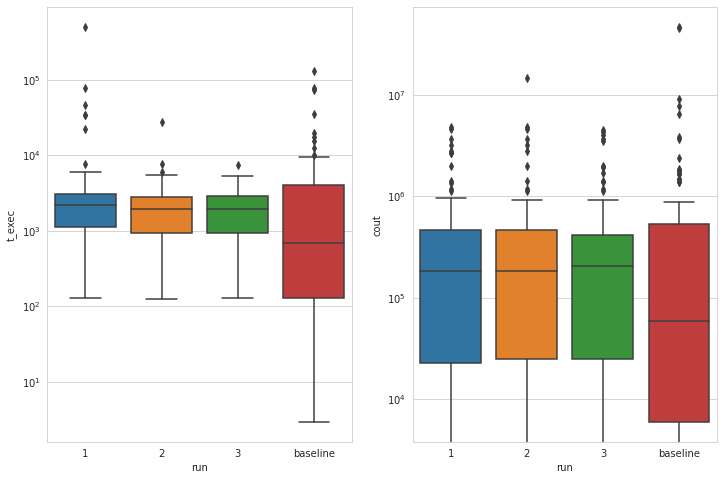

In [9]:
fig, (ax_t_exec, ax_cout) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
g = sns.boxplot(data=df_all, x="run", y="t_exec", ax=ax_t_exec)
g.set_yscale("log")
g = sns.boxplot(data=df_all, x="run", y="cout", ax=ax_cout)
g.set_yscale("log")

## For which queries did BAO improve the execution time substantially?

We will now look at which hints lead to the most impressive execution time improvements. In order to do so, we will first quantify how much the execution time improved per query. Afterwards, we take a look at the (positive) outliers and extract the hints that BAO applied.

**First up, determine the improvement factor**:

In [10]:
grp_query = df_bao.groupby("label")

In [11]:
def t_exec_decrease(grp):
    init_t_exec = grp[grp.run == 1].t_exec
    final_t_exec = grp[grp.run == 3].t_exec
    return init_t_exec / final_t_exec

**Aggregated overview:** how is the improvement factor (values $> 1$ constitute an improvement) distributed?

In [12]:
ser_rt_dec = grp_query.apply(t_exec_decrease)
ser_rt_dec.describe()

count    113.000000
mean       6.906549
std       42.516043
min        0.596580
25%        0.968942
50%        1.002781
75%        1.031984
max      443.647145
Name: t_exec, dtype: float64

**Next up**, we extract the relevant data from the entire BAO data frame. This includes the query plan for the third benchmark iteration, as well as the initial/final execution time. This process is rather technical and does not really provide any insight.

In [13]:
df_query = df_bao[["label", "query", "plan", "t_exec", "run"]].copy()
df_query = df_query.join(ser_rt_dec.reset_index(level=0).set_index("label").squeeze(), on="label", rsuffix="_dec")

In [14]:
def restructure_df(df_grp):
    run3 = select(df_grp, run=3)
    final_plan = run3.plan
    init_t_exec = select(df_grp, run=1).t_exec
    final_t_exec = run3.t_exec
    return pd.Series({"final_plan" : unwrap(final_plan),
                      "t_exec_init": unwrap(init_t_exec),
                      "t_exec_final": unwrap(final_t_exec)})

In [15]:
df_summarized = df_query.groupby(["label", "query", "t_exec_dec"])[["t_exec", "plan", "run"]].apply(restructure_df).reset_index()

At this point we are ready to get the final BAO query hints.

In [16]:
def unwrap_bao_hint(plan):
    return plan[0]["Bao"]["Bao recommended hint"]

In [17]:
df_summarized["bao_hint"] = df_summarized.final_plan.apply(unwrap_bao_hint)
bao_cols = ["label", "t_exec_dec", "t_exec_init", "t_exec_final", "bao_hint"]

**Finally**, we can extract the good outliers from the benchmark. Which queries are considered outliers can be customized below. The factor is the upper boundary, i.e. setting it to 0.1 will select the top 10% of improvements, setting it to 0.25 will select the top 25%, etc.

In [18]:
outliers = 0.1

"Brilliant" or "excellent" queries are those queries have an improvement at least as large as the outlier-quantile boundary. This improvement factor is calculated now:

In [19]:
brilliant_t_exec_dec = df_summarized.t_exec_dec.quantile(1-outliers)
brilliant_t_exec_dec

1.6405646108440959

**At last, here are the queries:**

In [20]:
df_excellent = df_summarized[df_summarized.t_exec_dec >= brilliant_t_exec_dec]
df_excellent[bao_cols].sort_values(by="t_exec_dec")

,label,t_exec_dec,t_exec_init,t_exec_final,bao_hint
11,13b,1.642539,3177.616,1934.576,SET enable_nestloop TO off;
68,28c,1.687700,3842.651,2276.857,SET enable_nestloop TO off;
13,13d,1.747584,5017.809,2871.284,SET enable_nestloop TO off;
70,29b,1.779571,4368.558,2454.838,SET enable_mergejoin TO off;
12,13c,1.782854,3105.081,1741.635,SET enable_nestloop TO off;
65,27c,14.291160,22393.604,1566.955,SET enable_mergejoin TO off; SET enable_indexs...
4,11b,14.305157,5440.151,380.293,SET enable_mergejoin TO off;
52,23a,39.683696,34453.980,868.215,SET enable_mergejoin TO off;
53,23b,40.271534,33654.679,835.694,SET enable_mergejoin TO off;
54,23c,53.725875,46207.852,860.067,SET enable_mergejoin TO off;


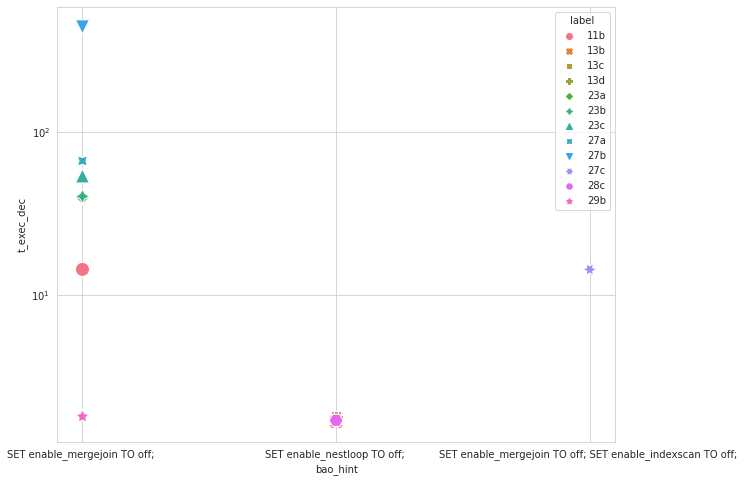

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(data=df_excellent, x="bao_hint", y="t_exec_dec", hue="label", style="label", s=200, ax=ax)
g.set_yscale("log")

## Which query hints did BAO apply during the benchmark?

In [22]:
df_bao["bao_hint"] = df_bao.plan.apply(unwrap_bao_hint)

The absolute number of times each query hint was applied per run:

In [23]:
bao_hint_hue_order = df_bao.bao_hint.sort_values().unique()

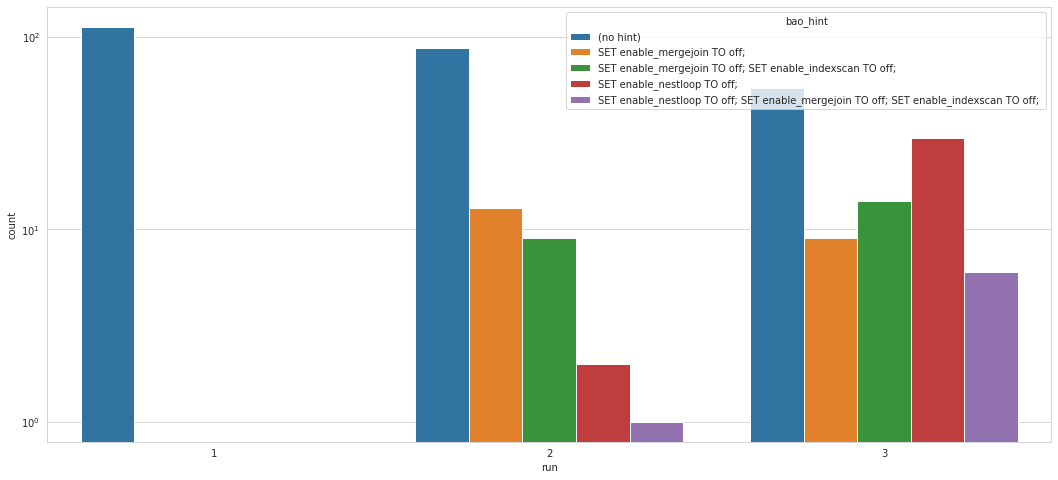

In [24]:
fig, ax = plt.subplots(figsize=(18,8))
g = sns.countplot(data=df_bao, x="run", hue="bao_hint", hue_order=bao_hint_hue_order, ax=ax)
g.set_yscale("log")

The influence each query hint had on the runtime, relative to the runtime during the previous iteration:

In [25]:
def per_iteration_runtime_improvement(query_grp):
    improvement = query_grp.t_exec.shift(1) / query_grp.t_exec
    return pd.DataFrame({"label": query_grp.label, "run": query_grp.run, "t_exec_rel_improv": improvement.values})

In [26]:
df_bao = df_bao.merge(df_bao.groupby("label").apply(per_iteration_runtime_improvement), on=["label", "run"])

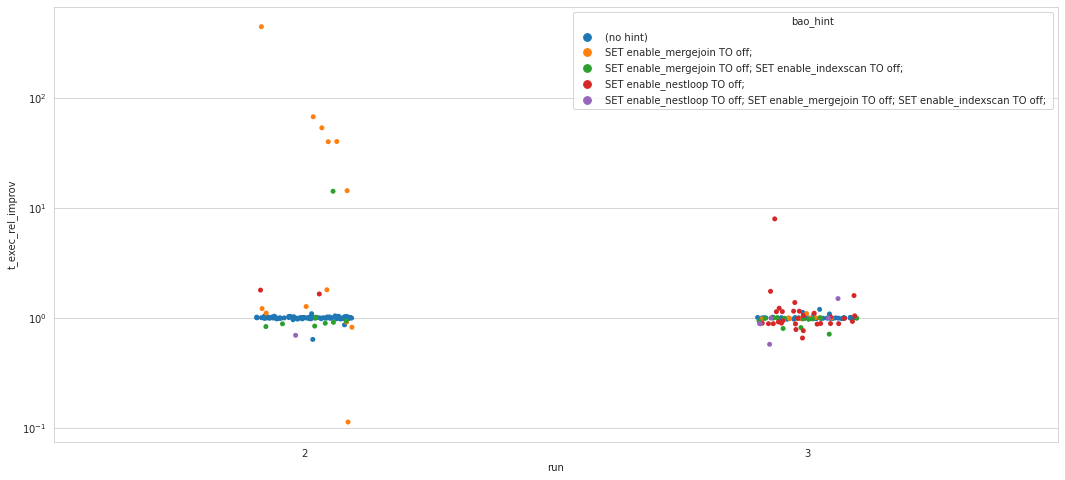

In [27]:
df_bao_r1_r2 = pd.concat([select(df_bao, run=2), select(df_bao, run=3)]).sort_values(by="bao_hint")
fig, ax = plt.subplots(figsize=(18,8))
g = sns.stripplot(data=df_bao_r1_r2, x="run", y="t_exec_rel_improv", hue="bao_hint", hue_order=bao_hint_hue_order, ax=ax)
g.set_yscale("log")

The improvement per benchmark iteration:

In [28]:
df_bao_r1_r2.groupby("run")["t_exec_rel_improv"].describe()

,count,mean,std,min,25%,50%,75%,max
run,,,,,,,,
2,113.0,6.903930,42.530016,0.113615,0.995331,1.003788,1.023340,443.665857
3,113.0,1.065042,0.669779,0.577855,0.985454,0.998757,1.006198,7.961166
